This notebook is meant to help you get started on your own projects in the **Petals to the Metal** competition. Check out the **Getting Started** notebook and our **Learn With Me** video for details.

# Load Helper Functions #

In [1]:
from petal_helper import *

Tensorflow version 2.2.0
Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Create Distribution Strategy #

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load the Competition Data #

In [3]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()

print("Training:", ds_train)
print("Validation:", ds_valid)

Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>


# Explore the Data #

Try using some of the helper functions described in the **Getting Started** tutorial to explore the dataset.

In [4]:
print ("Number of classes: {}".format(len(CLASSES)))

print ("First five classes, sorted alphabetically:")
for name in sorted(CLASSES)[:5]:
    print(name)

Number of classes: 104
First five classes, sorted alphabetically:
alpine sea holly
anthurium
artichoke
azalea
balloon flower


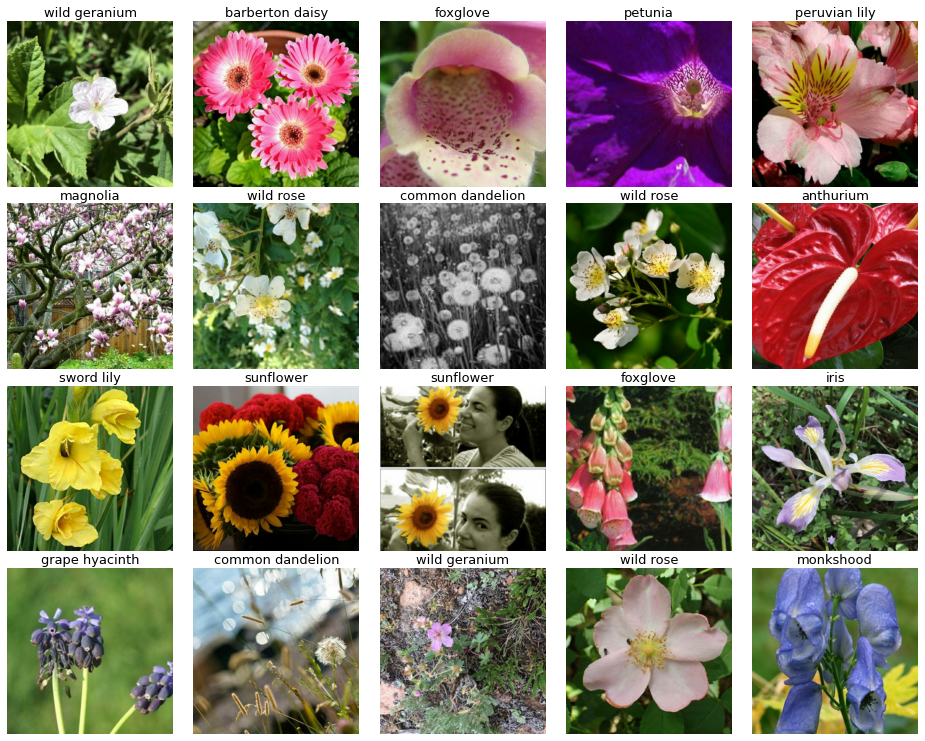

In [5]:
# Peek at training data
one_batch = next(iter(ds_train.unbatch().batch(20)))
display_batch_of_images(one_batch)

# Define Model #

In [6]:
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


# Train Model #

In [7]:
# Define the batch size. This will be 16 with TPU off and 128 with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Define training epochs for committing/submitting. (TPU on)
EPOCHS = 12
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)

Epoch 1/12
99/99 [==============================] - 27s 273ms/step - sparse_categorical_accuracy: 0.0799 - loss: 4.1470 - val_sparse_categorical_accuracy: 0.1307 - val_loss: 3.9021
Epoch 2/12
99/99 [==============================] - 18s 179ms/step - sparse_categorical_accuracy: 0.1699 - loss: 3.7731 - val_sparse_categorical_accuracy: 0.1985 - val_loss: 3.6584
Epoch 3/12
99/99 [==============================] - 17s 171ms/step - sparse_categorical_accuracy: 0.2056 - loss: 3.5604 - val_sparse_categorical_accuracy: 0.2249 - val_loss: 3.4656
Epoch 4/12
99/99 [==============================] - 17s 168ms/step - sparse_categorical_accuracy: 0.2390 - loss: 3.3775 - val_sparse_categorical_accuracy: 0.2621 - val_loss: 3.3124
Epoch 5/12
99/99 [==============================] - 16s 166ms/step - sparse_categorical_accuracy: 0.2708 - loss: 3.2200 - val_sparse_categorical_accuracy: 0.2670 - val_loss: 3.1755
Epoch 6/12
99/99 [==============================] - 17s 169ms/step - sparse_categorical_accurac

Examine training curves.

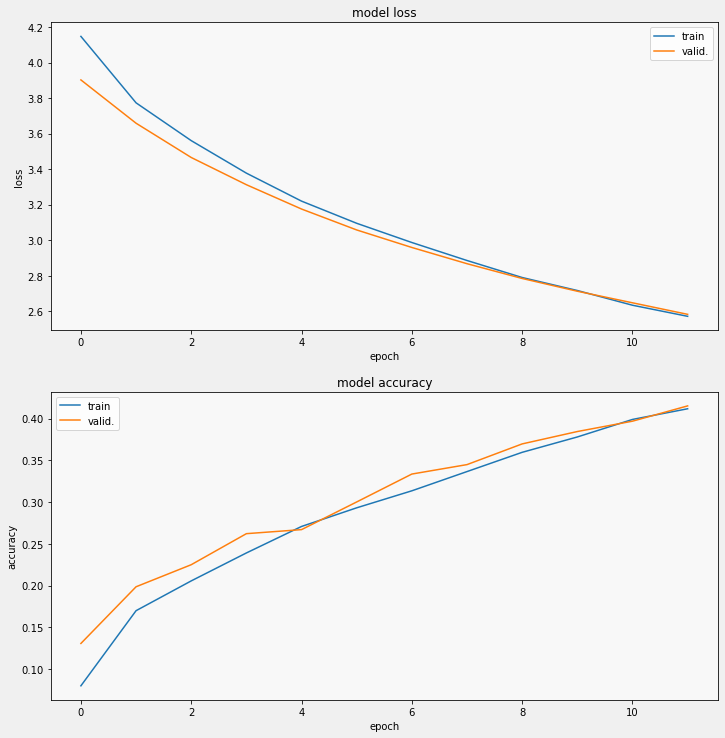

In [8]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

# Validation #

Create a confusion matrix.

In [9]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


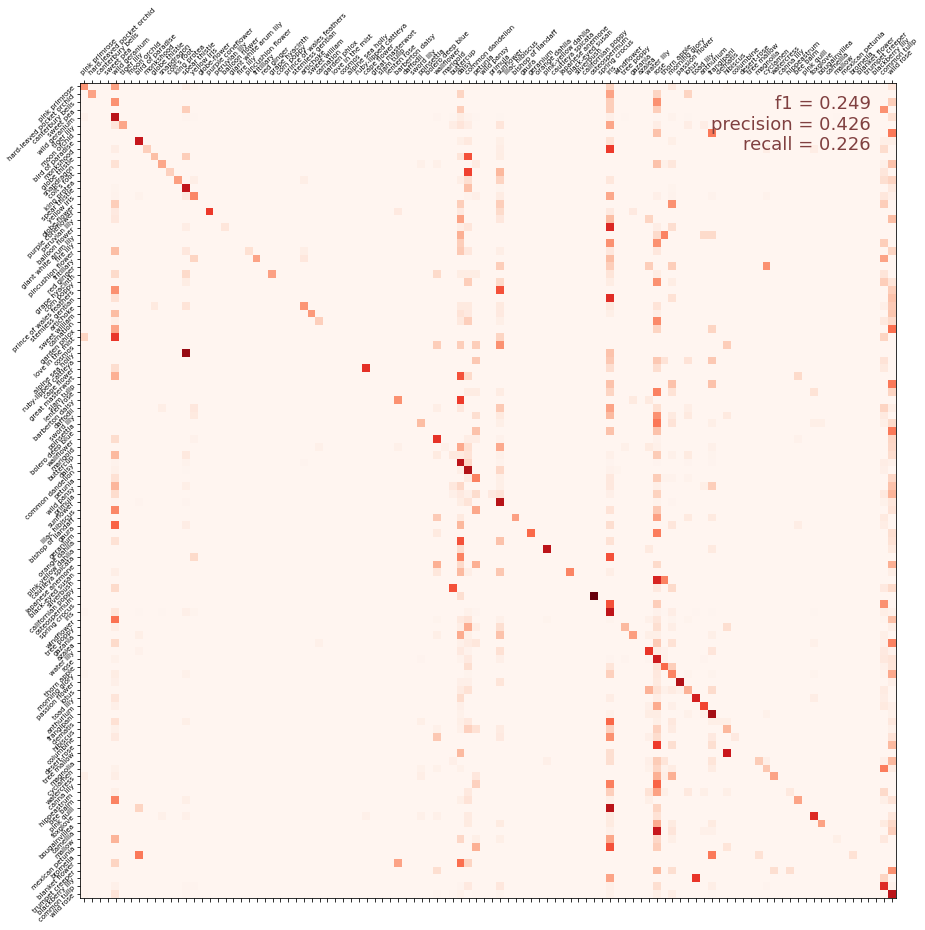

In [10]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

Look at examples from the dataset, with true and predicted classes.

In [11]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

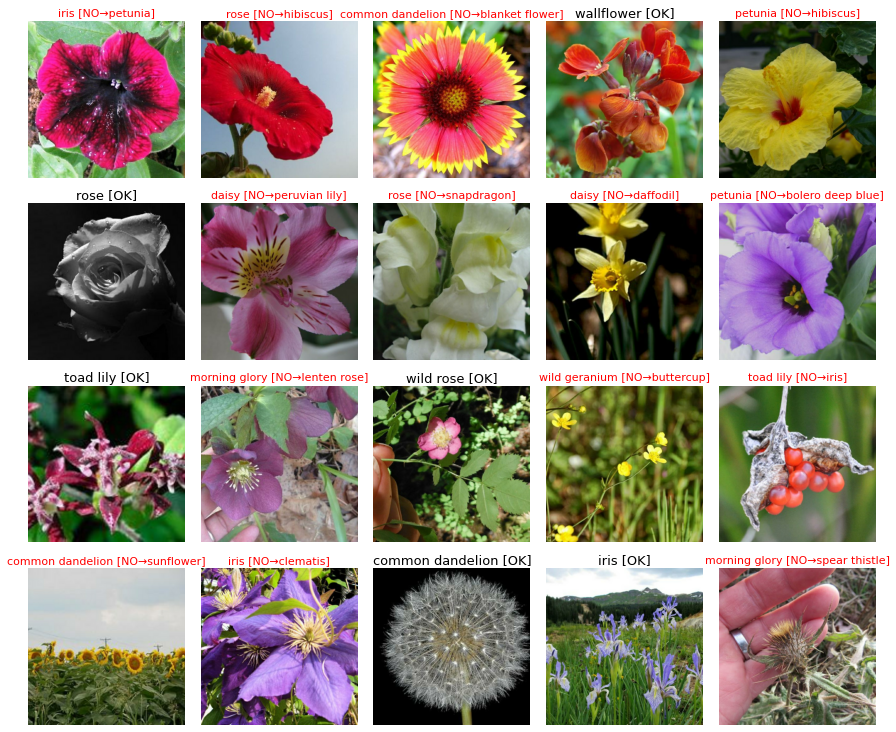

In [12]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Test Predictions #

Create predictions to submit to the competition.

In [13]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Computing predictions...
[ 67  28 103 ...  48  53  53]
Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,103
00e4f514e,103
59d1b6146,53
8d808a07b,53
aeb67eefb,103
53cfc6586,48
aaa580243,103
